In [18]:
%load_ext autoreload
%autoreload 2

import copy
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits
import matplotlib.pyplot as plt

from memflow.dataset.data import RootData
vector.register_awkward()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# HH data

In [3]:
data = RootData(
    files = [
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_4_2016/results/GluGluToHHTo2B2VTo2L2Nu_node_SM.root',
    ], # these are the files we want to load, there can be several
    treenames = [
        'gen_HH;1',
    ], # this is the name of the gen-level tree
    lazy = True, # Explained above.
    #N = 1000, # this is to load only the N first events in the tree, 
    # in case you are just playing/debugging and don't need to load all the data (can be slow)
    # to load all, just comment out
)
print (data_hard)

Data object
Loaded branches:
   ... file: 84565
   ... sample: 84565
   ... tree: 84565
Branch in files not loaded:
   ... H1_E
   ... H1_Px
   ... H1_Py
   ... H1_Pz
   ... H1_eta
   ... H1_idx
   ... H1_mass
   ... H1_pdgId
   ... H1_phi
   ... H1_pt
   ... H1_sum_E
   ... H2_E
   ... H2_Px
   ... H2_Py
   ... H2_Pz
   ... H2_eta
   ... H2_idx
   ... H2_mass
   ... H2_pdgId
   ... H2_phi
   ... H2_pt
   ... H2_sum_E
   ... ISR_10_E
   ... ISR_10_Px
   ... ISR_10_Py
   ... ISR_10_Pz
   ... ISR_10_eta
   ... ISR_10_idx
   ... ISR_10_mass
   ... ISR_10_parent
   ... ISR_10_pdgId
   ... ISR_10_phi
   ... ISR_10_pt
   ... ISR_11_E
   ... ISR_11_Px
   ... ISR_11_Py
   ... ISR_11_Pz
   ... ISR_11_eta
   ... ISR_11_idx
   ... ISR_11_mass
   ... ISR_11_parent
   ... ISR_11_pdgId
   ... ISR_11_phi
   ... ISR_11_pt
   ... ISR_12_E
   ... ISR_12_Px
   ... ISR_12_Py
   ... ISR_12_Pz
   ... ISR_12_eta
   ... ISR_12_idx
   ... ISR_12_mass
   ... ISR_12_parent
   ... ISR_12_pdgId
   ... ISR_12_phi
 

In [19]:
def count_particles(data,particle):
    N_tot = ak.num(data[f'{particle}_pt'],axis=0)
    N_sel = ak.sum(data[f'{particle}_pt'] > 0)
    print (f'{particle} : N_sel = {N_sel} / N_tot = {N_tot}')
    return N_sel,N_tot

In [21]:
for particle in ['H1','H2','W_plus','W_minus','Z1','Z2','bottom','antibottom']:
    count_particles(data,particle)

H1 : N_sel = 84565 / N_tot = 84565
H2 : N_sel = 84565 / N_tot = 84565
W_plus : N_sel = 80929 / N_tot = 84565
W_minus : N_sel = 80929 / N_tot = 84565
Z1 : N_sel = 3636 / N_tot = 84565
Z2 : N_sel = 3636 / N_tot = 84565


KeyError: 'Key bottom_pt is not present in tree'

# DY data

In [41]:
data = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v7_2016/results/DYToLL_2J.root',
    ], # these are the files we want to load, there can be several
    treenames = [
        'reco_DL;1',
    ], # this is the name of the gen-level tree
    lazy = True, # Explained above.
    N = 500000, # this is to load only the N first events in the tree, 
    # in case you are just playing/debugging and don't need to load all the data (can be slow)
    # to load all, just comment out
)
# print (data)

# mask_resolved = np.logical_and.reduce(                                                  
#     (                                                                                   
#         data['flag_SR']==1,                                                        
#         data['n_AK4']>=2,                                                          
#         data['n_AK4B']>=1,                                                         
#     )                                                                                   
# )         
# print (len(mask_resolved),sum(mask_resolved))
# data.cut(mask_resolved) 

In [42]:
n_jets = 10
n_e = 2
n_m = 2
jets = data.make_particles(
    'jets',
    {
        'px'      : [f'j{i}_Px' for i in range(1,n_jets+1)],
        'py'      : [f'j{i}_Py' for i in range(1,n_jets+1)],
        'pz'      : [f'j{i}_Pz' for i in range(1,n_jets+1)],
        'E'       : [f'j{i}_E' for i in range(1,n_jets+1)],
        'btag'    : [f'j{i}_btag' for i in range(1,n_jets+1)],
        'btagged' : [f'j{i}_btagged' for i in range(1,n_jets+1)],
    },
    lambda vec: vec.E > 0.,
)
electrons = data.make_particles(
    'electrons',
    {
        'px'      : [f'e{i}_Px' for i in range(1,n_e+1)],
        'py'      : [f'e{i}_Py' for i in range(1,n_e+1)],
        'pz'      : [f'e{i}_Pz' for i in range(1,n_e+1)],
        'E'       : [f'e{i}_E' for i in range(1,n_e+1)],
        'pdgId'   : [f'e{i}_pdgId' for i in range(1,n_e+1)],
        'charge'  : [f'e{i}_charge' for i in range(1,n_e+1)],
    },
    lambda vec: vec.E > 0.,
)
n_m = 4
muons = data.make_particles(
    'muons',
    {
        'px'      : [f'm{i}_Px' for i in range(1,n_m+1)],
        'py'      : [f'm{i}_Py' for i in range(1,n_m+1)],
        'pz'      : [f'm{i}_Pz' for i in range(1,n_m+1)],
        'E'       : [f'm{i}_E' for i in range(1,n_m+1)],
        'pdgId'   : [f'm{i}_pdgId' for i in range(1,n_m+1)],
        'charge'  : [f'm{i}_charge' for i in range(1,n_m+1)],
    },
    lambda vec: vec.E > 0.,
)


In [60]:
mll = np.concatenate(
    (
        ak.sum(electrons[ak.num(electrons)==2],axis=1).mass.to_numpy(),
        ak.sum(muons[ak.num(muons)==2],axis=1).mass.to_numpy(),
    ),
    axis= 0,
)
print (mll)

[87.83765583 90.66354476 87.20821033 ... 91.3244478  93.58008556
 93.52402359]


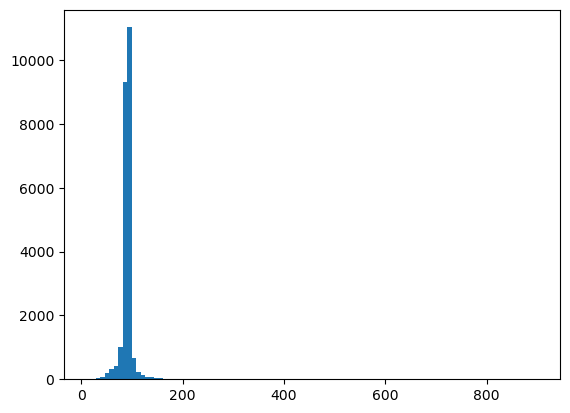

In [62]:
plt.hist(mll,bins=100)
# plt.yscale('log')
plt.show()

In [94]:
data = RootData(
    files = [
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v7_2016/results/DYJetsToLL_M-10to50.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v7_2016/results/DYJetsToLL_M-50.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v7_2016/results/DYToLL_0J.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v7_2016/results/DYToLL_1J.root',
        '/home/ucl/cp3/fbury/scratch/MEM_data/Transfermer_v7_2016/results/DYToLL_2J.root',
    ], # these are the files we want to load, there can be several
    treenames = [
        'gen_DY;1',
    ], # this is the name of the gen-level tree
    lazy = True, # Explained above.
    N = 100000, # this is to load only the N first events in the tree, 
    # in case you are just playing/debugging and don't need to load all the data (can be slow)
    # to load all, just comment out
)


In [95]:
lep_Z = data.make_particles(
    'lep_Z',
    {
        'px'  : [
            'lep_from_Z_Px',
            'antilep_from_Z_Px',
        ],
        'py'  : [
            'lep_from_Z_Py',
            'antilep_from_Z_Py',
        ],
        'pz'  : [
            'lep_from_Z_Pz',
            'antilep_from_Z_Pz',
        ],
        'E'  : [
            'lep_from_Z_E',
            'antilep_from_Z_E',
        ],
        'pdgId'  : [
            'lep_from_Z_pdgId',
            'antilep_from_Z_pdgId',
        ],
    },
    lambda vec: vec.E > 0.,
)
lep_nonres = data.make_particles(
    'lep_nonres',
    {
        'px'  : [
            'lep_from_nonres_Px',
            'antilep_from_nonres_Px',
        ],
        'py'  : [
            'lep_from_nonres_Py',
            'antilep_from_nonres_Py',
        ],
        'pz'  : [
            'lep_from_nonres_Pz',
            'antilep_from_nonres_Pz',
        ],
        'E'  : [
            'lep_from_nonres_E',
            'antilep_from_nonres_E',
        ],
        'pdgId'  : [
            'lep_from_nonres_pdgId',
            'antilep_from_nonres_pdgId',
        ],
    },
    lambda vec: vec.E > 0.,
)


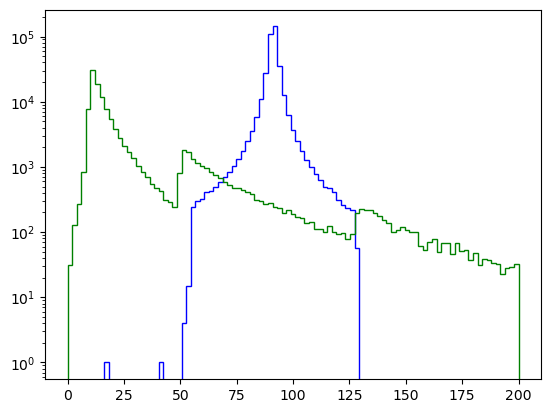

In [96]:
plt.hist(
    ak.sum(lep_Z[ak.num(lep_Z,axis=1)>0],axis=1).mass.to_numpy(),
    bins = np.linspace(0,200,100),
    histtype = 'step',
    color = 'b'
)
plt.hist(
    ak.sum(lep_nonres[ak.num(lep_nonres,axis=1)>0],axis=1).mass.to_numpy(),
    bins = np.linspace(0,200,100),
    histtype = 'step',
    color = 'green',
)
plt.yscale('log')
plt.show()